**EfficientNetB0 Baseline model Training and Evaluation** 

    No of Epochs : 4    [Used lr_find() to find the best learning rate and Data Augmentation on training dataset]
 
    Top K Accuracy : 0.83  
    Validation Accuracy : 0.79 

    This is the first baseline model trained without manual cleaning , learning rate optimizer , TTA and got low accuracy. 

In [ ]:
#checking the number of cpus available 
!cat /proc/cpuinfo |grep "cpu cores" |uniq

cpu cores	: 2


In [ ]:
#GPU accelerator detection 
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed May 12 06:38:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    35W / 250W |    993MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#checking available RAM 
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
#installing Torchvision 
!pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
#importing fastai vision
from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
#use only to run the code in cpu 
#import fastai
#fastai.device = torch.device('cpu')

In [ ]:
!mkdir /content/models #creating /content/models for saving the model 

In [ ]:
#downloading the food 101 data from url 
path = untar_data(URLs.FOOD)

In [ ]:
path.ls()

[PosixPath('/root/.fastai/data/food-101/labels.txt'),
 PosixPath('/root/.fastai/data/food-101/classes.txt'),
 PosixPath('/root/.fastai/data/food-101/images'),
 PosixPath('/root/.fastai/data/food-101/test.txt'),
 PosixPath('/root/.fastai/data/food-101/h5'),
 PosixPath('/root/.fastai/data/food-101/train.txt'),
 PosixPath('/root/.fastai/data/food-101/test.json'),
 PosixPath('/root/.fastai/data/food-101/train.json')]

In [ ]:
#creating train and test dataset 
train_path = '/root/.fastai/data/food-101/train.txt'
test_path = '/root/.fastai/data/food-101/test.txt'

def filelist2df(path):
    df = pd.read_csv(path,delimiter='/', header = None, names=['label','name'])
    df['name'] = df['label'].astype(str)+"/"+df['name'].astype(str)+".jpg"
    return df
train_df = filelist2df(train_path)
test_df = filelist2df(test_path)

In [ ]:
train_df.head()

,label,name
0,apple_pie,apple_pie/1005649.jpg
1,apple_pie,apple_pie/1014775.jpg
2,apple_pie,apple_pie/1026328.jpg
3,apple_pie,apple_pie/1028787.jpg
4,apple_pie,apple_pie/1043283.jpg


In [ ]:
print('Shape of Training data :',train_df.shape)

Shape of Training data : (75750, 2)


In [ ]:
print('Shape of Test data :',test_df.shape)

Shape of Test data : (25250, 2)


In [ ]:
#fast ai will get the label automatically from the folders
#taken from kaggle/ for creating the split for validation
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(40)

**EfficientnetB0**

In [ ]:
#EfficientNet0 and image size 224 and see how fast it converges
bs = 64
img_size = 224 

In [ ]:
#defining the data augumentation
#There are two arguments for this 
#First Argument : transformation for the training set  #second Argument - transformation for the validation set (transform not done for validation data )
ds_tfms=([RandTransform(tfm=TfmCrop (crop_pad),kwargs={'row_pct':(0,1),'col_pct':(0,1),'padding_mode':'reflection'},p=1.0,resolved={},do_run=True,is_random=True),
          RandTransform(tfm=TfmCoord (symmetric_warp),kwargs={'magnitude':(-0.2,0.2)},p=0.75,resolved={},do_run=True,is_random=True),
          RandTransform(tfm=TfmAffine(rotate),kwargs={'degrees':(-40,40)},p=0.75,resolved={},do_run=True,is_random=True),
          RandTransform(tfm=TfmAffine(flip_affine),kwargs={},p=0.75,resolved={},do_run=True,is_random=True),
          RandTransform(tfm=TfmAffine(zoom),kwargs={'scale':(1.0,1.4),'row_pct':(0,1),'col_pct':(0,1)},p=0.75,resolved={},do_run=True,is_random=True),
          RandTransform(tfm=TfmLighting(brightness),kwargs={'change':(0.35,0.65)},p=0.75,resolved={},do_run=True,is_random=True),
          RandTransform(tfm=TfmLighting(contrast),kwargs={'scale':(0.7,1.43)},p=0.75,resolved={},do_run=True,is_random=True),
          RandTransform(tfm=TfmCoord(jitter),kwargs={'magnitude':(-0.01,0.01)},p=0.3,resolved={},do_run=True,is_random=True),
          RandTransform(tfm=TfmCoord(skew),kwargs={'direction':(0,7),'magnitude':(0.2)},p=0.75,resolved={},do_run=True,is_random=True),
          RandTransform(tfm=TfmAffine(squish),kwargs={'scale':(0.42,2.4),'row_pct':(0,1),'col_pct':(0,1)},p=0.75,resolved={},do_run=True,is_random=True)],
          [RandTransform(tfm=TfmCrop(crop_pad),kwargs={},p=1.0,resolved={},do_run=True,is_random=True)])

In [ ]:
#Doing the transformation for the train data 
#Split_by will split the data for validation
#Label specification from where the label has to be taken
#What kind of transformation , batchsize and normalization 
data=(ImageList.from_df(df=train_df,path=path/'images',cols=1)
      .split_by_rand_pct(0.2)
      .label_from_df(cols=0)
      .transform(ds_tfms,size=img_size)
      .databunch(bs=bs)
      .normalize(imagenet_stats))

In [ ]:
#installing efficientNet  
pip install --upgrade efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=38477ee8a67f55e55a176b5079e755878fc0de8ddbd9a52effd2fff6bb48c90e
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [ ]:
#Importing the Efficient net from pytorch : Original paper implemented in Keras (tpu)
#importing efficientNet from pyTorch - Third party implementation 
from efficientnet_pytorch import EfficientNet

In [ ]:
#Loading the pretrained efficientNetB0
model = EfficientNet.from_pretrained("efficientnet-b0")

Loaded pretrained weights for efficientnet-b0


In [ ]:
top_5 = partial(top_k_accuracy,k=5)
learn=Learner(data,model,metrics=[accuracy,top_5], callback_fns=ShowGraph).to_fp16() #by default float 32 training in 16 bits takes only half the size. 
learn.split(lambda m:(model._conv_head,)) #This helps to break the network in three parts and train with different learning rates 

In [ ]:
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [ ]:
#lr = 9e-3
#learn.fit_one_cycle(1,max_lr=slice(lr))
#learn.save('/content/models/food-101-train-epoch-v1')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.954827,1.955296,0.567261,0.827921,11:34
1,1.624377,1.433805,0.653267,0.865809,11:34
2,1.202551,0.915790,0.763762,0.924488,11:26
3,0.895407,0.798578,0.794389,0.939010,11:28


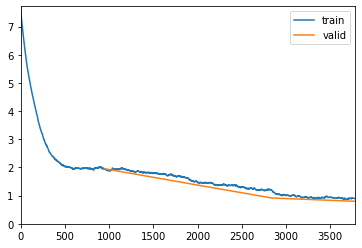

In [ ]:
lr = 9e-3  #learning rate initialization 
learn.fit_one_cycle(4,max_lr=slice(lr))
learn.save('/content/drive/MyDrive/food-101-train-epoch-4')

In [ ]:
#Forming the test data to validate the test accuracy 
test_data=(ImageList.from_df(df=test_df,path=path/'images',cols=1)
      .split_none()
      .label_from_df(cols=0)
      .transform(ds_tfms,size=img_size)
      .databunch(bs=bs)
      .normalize(imagenet_stats))

In [ ]:
top_5 = partial(top_k_accuracy,k=5)
learn=Learner(test_data,model,metrics=[accuracy,top_5]).to_fp16() 
#by default float 32 training in 16 bits..takes only half the size. 
learn.load('/content/models/food-101-train-epoch-v1')

In [ ]:
learn.validate(test_data.train_dl )

[1.0188521, tensor(0.7241), tensor(0.9147)]

In [ ]:
# using fastai widget to do data cleaning
from fastai.widgets import *
 
data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .split_none()
        .label_from_df(cols=0)
        .transform(ds_tfms, size=img_size)
        .databunch())
 
learn_cln = Learner(data, model, metrics=[accuracy, top_5]).to_fp16()
learn_cln.load('path_to_trained_model')
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)
 
# manually removing some of the noise in the dataset. 
ImageCleaner(ds, idxs, path)

Learner(data=ImageDataBunch;

Train: LabelList (25250 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: /root/.fastai/data/food-101/images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /root/.fastai/data/food-101/images;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.01000000000

In [ ]:
preds, y = learn.get_preds(test_data)

In [ ]:
test_df.label.unique

<bound method Series.unique of 0        apple_pie
1        apple_pie
2        apple_pie
3        apple_pie
4        apple_pie
           ...    
25245      waffles
25246      waffles
25247      waffles
25248      waffles
25249      waffles
Name: label, Length: 25250, dtype: object>

In [ ]:
import pandas as pd

In [ ]:
test_df.label.value_counts()

beef_carpaccio          250
sushi                   250
caesar_salad            250
french_toast            250
peking_duck             250
                       ... 
chicken_quesadilla      250
clam_chowder            250
strawberry_shortcake    250
greek_salad             250
grilled_salmon          250
Name: label, Length: 101, dtype: int64

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
